## 2D Task-2: Modelling Uncertainty Multiple Linear Regression
We will run a multiple linear regression model on a dataset with the target as medical charges coverable by an insurance varying with the features:
- Age: Age of the person insured
- Body Mass Index (BMI): A measure of the insured's physical health
- Children: Number of children of the insured covered by the insurance
- Smoker: If the insured person is a smoker or not

Our target value is the column of **Charges**. It is the medical costs that the insurance will cover.

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Laying out all the important functions required for performing a Multiple Linear Regression

1. normalize_z(df): Standardization: Write a function that takes in data frame where all the column are the features and normalize each column according to the following formula.

    $$normalized = \frac{data - \mu}{\sigma}$$

    where $\mu$ is the mean of the data and $\sigma$ is the standard deviation of the data. The function returns a new dataframe.

        Using following functions from Pandas:
        - df.mean(axis=0): To calculate the mean along the index axis.
        - df.std(axis=0): To calculate the standard deviation along the index axis.


2. get_features_targets(df, feature_names, target_names): To get the columns for the features and the targets from the input argument data frame. The function takes in Pandas' dataframe and two lists. The first list is for the feature names and the other list is for the target names.


3. prepare_feature(df_feature): Takes in a data frame for the feature. The function converts the data frame to a numpy array and changes it into a column vector. The function adds a column of constant 1s in the first column.


4. prepare_target(df_target): Takes in a data frame for the target. The function converts the data frame to a numpy array and changes it into column vectors. 


5. predict(df_feature, beta): This standardizes the feature using z normalization, changes it to a Numpy array, and adds a column of constant 1s. prepare_feature() is used for this purpose. Lastly, this function calls predict_norm() to get the predicted y values.


6. predict_norm(X, beta): Calculates the straight line equation after standardization and adds column for constant 1.


7. split_data(df_feature, df_target, random_state=None, test_size=0.5): Split the Data Frame randomly. The function has the following arguments:
    - df_feature: Data frame for the features.
    - df_target: Data frame for the target.
    - random_state: Seed used to split randomly.
    - test_size: Fraction for the test data set (0 to 1), by default is set to 0.5

    The output of the function is a tuple of four items:
    - df_feature_train: Train set for the features data frame
    - df_feature_test: Test set for the features data frame
    - df_target_train: Train set for the target data frame
    - df_target_test: Test set for the target data frame

8. r2_score(y, ypred): Calculates the coefficient of determination as given by the following equations.

    $$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$


9. mean_squared_error(target, pred): Calculate the MSE

    $$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$

10. adjusted_rsquare(rsquare, samplesize, features): r^2 is not an accurate measure. The adjusted r^2 method can provide a more precise view of the correlation by additionally taking into account the number of independent variables are added to the particular model.






In [149]:
def normalize_z(df):
    dfout = (df - df.mean(axis=0))/df.std(axis=0)
    return dfout
    pass

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    feature = df_feature.to_numpy()
    ones = np.ones((df_feature.shape[0],1))
    X = np.concatenate((ones, feature), axis=1)
    return X
    pass

def prepare_target(df_target):
    return df_target.to_numpy()
    pass

def predict(df_feature, beta):
    dfout = normalize_z(df_feature)
    X = prepare_feature(dfout)
    return predict_norm(X, beta)
    pass

def predict_norm(X, beta):
    y = np.matmul(X, beta)
    return y
    pass

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indexes = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k = int(test_size * len(indexes))
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    ymean = np.mean(y)
    sstot = np.sum((y-ymean)**2)
    ssres = np.sum((y-ypred)**2)

    r_2 = 1 - (ssres/sstot)
    return r_2
    pass

def mean_squared_error(target, pred):
    n = target.shape[0]
    return (1/n)*np.sum((target-pred)**2)
    pass

def adjusted_rsquare(rsquare, samplesize, features):
    result = 1 - ((1-rsquare)*(samplesize-1)/(samplesize-features-1))
    return result
    

### Reading the Dataset

In [150]:
insurance_data = "/Users/rmurarishetti/Documents/DDW_Term 3/insurance.csv"
df_insurance = pd.read_csv(insurance_data)
df_insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


###  Visualizing the Dataset
- Let us see if any relationships can be uncovered by visualising the dataset using seaborn's pairplot feature

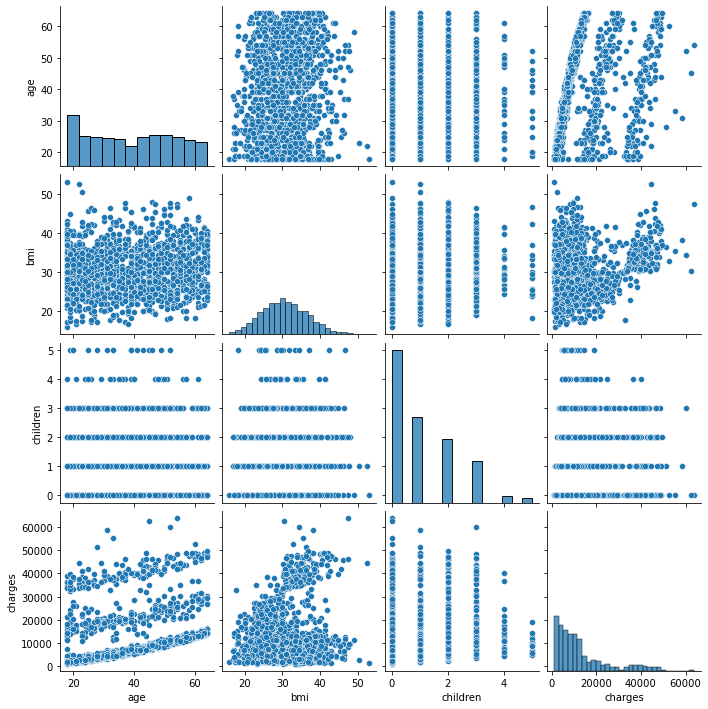

In [151]:
sns.pairplot(df_insurance)

### Multiple Linear Regression on Raw Data
- Let us perform a multiple linear regression on our unedited dataset
- We shall map a 'yes' in smoker column to 1 and 'no' to a 0.

In [152]:
def smokermapping(input):
    if input == "yes":
        return 1
    else:
        return 0

In [153]:
df_insurance_copy = df_insurance.copy()
df_insurance_copy["smoker"] = df_insurance["smoker"].apply(smokermapping)
df_insurance_copy

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,1,southwest,16884.92400
1,18,male,33.770,1,0,southeast,1725.55230
2,28,male,33.000,3,0,southeast,4449.46200
3,33,male,22.705,0,0,northwest,21984.47061
4,32,male,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,0,northwest,10600.54830
1334,18,female,31.920,0,0,northeast,2205.98080
1335,18,female,36.850,0,0,southeast,1629.83350
1336,21,female,25.800,0,0,southwest,2007.94500


In [154]:
df_feature, df_targets = get_features_targets(df_insurance_copy, ["age", "bmi", "children", "smoker"], ["charges"])
df_features = normalize_z(df_feature)
df_features_train, df_features_test, df_targets_train, df_targets_test = split_data(df_features, df_targets, random_state=1000, test_size=0.6)

In [155]:
def compute_cost(X, y, Beta):
    J = 0
    m = X.shape[0]
    ypred = np.matmul(X, Beta)
    error = y - ypred
    error_sq = np.matmul(error.T, error)
    J = (1/2*m)*error_sq
    return J[0][0]

In [156]:
def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = np.zeros((num_iters, 1))
    for n in range(num_iters):
        driv = np.matmul(X.T, ((np.matmul(X,beta))-y))
        beta = beta - ((1/m))*alpha*driv
        J_storage[n] = compute_cost(X, y, beta)
    return beta, J_storage
    

In [157]:
beta = np.zeros((5,1))
X = prepare_feature(df_features_train)
target = prepare_target(df_targets_train)
beta, J_storage = gradient_descent(X, target, beta, 0.1, 1500)
print(beta)

[[13734.68650041]
 [ 3406.80890654]
 [ 1725.67965252]
 [  519.55383126]
 [ 9764.5090263 ]]


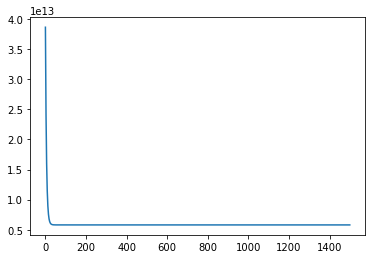

In [158]:
plt.plot(J_storage)

In [159]:
pred = predict(df_features_test, beta)
target = prepare_target(df_targets_test)
rmse = (mean_squared_error(target, pred))**0.5
r_score = r2_score(target, pred)

print(r_score, rmse)

0.7662479073326509 5861.39036036813


In [174]:
adj_rsq = adjusted_rsquare(r_score, 1338, 4)
print(adj_rsq)

0.7655464756967398


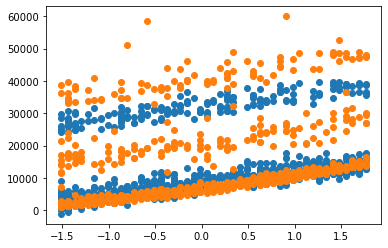

In [160]:
plt.scatter(df_features_test["age"], pred)
plt.scatter(df_features_test["age"], target)

conclude using r score, adjusted r score, and rmse

### Optimizing our regression
- Let us observe an optimal range to train our data on.
- It is observed that the bulk of the charges that are covered by an insurance are in the range **$0 to $17,500**.

<AxesSubplot:xlabel='age', ylabel='charges'>

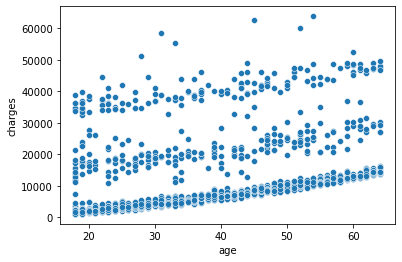

In [161]:
sns.scatterplot(x=df_insurance["age"], y = df_insurance["charges"])

### Cleaning and Refining the Data
Now that we have observed that the bulk of charges covered fall in the range mentioned above. Let us also convert the categorical data of smoking into numerical data.

- It is a well known fact that one is prone to severe illnesses as a consequence of smoking.
- We shall map a yes under the smoking column to 1 while a no to 0.

In [162]:
df_insurance_cleaned = df_insurance.copy()
rowselector = (df_insurance["charges"]<=17500)
df_insurance_cleaned = df_insurance_cleaned.loc[rowselector, :]
df_insurance_cleaned["smoker"] = df_insurance["smoker"].apply(smokermapping)
df_insurance_cleaned

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,1,southwest,16884.9240
1,18,male,33.77,1,0,southeast,1725.5523
2,28,male,33.00,3,0,southeast,4449.4620
4,32,male,28.88,0,0,northwest,3866.8552
5,31,female,25.74,0,0,southeast,3756.6216
...,...,...,...,...,...,...,...
1332,52,female,44.70,3,0,southwest,11411.6850
1333,50,male,30.97,3,0,northwest,10600.5483
1334,18,female,31.92,0,0,northeast,2205.9808
1335,18,female,36.85,0,0,southeast,1629.8335


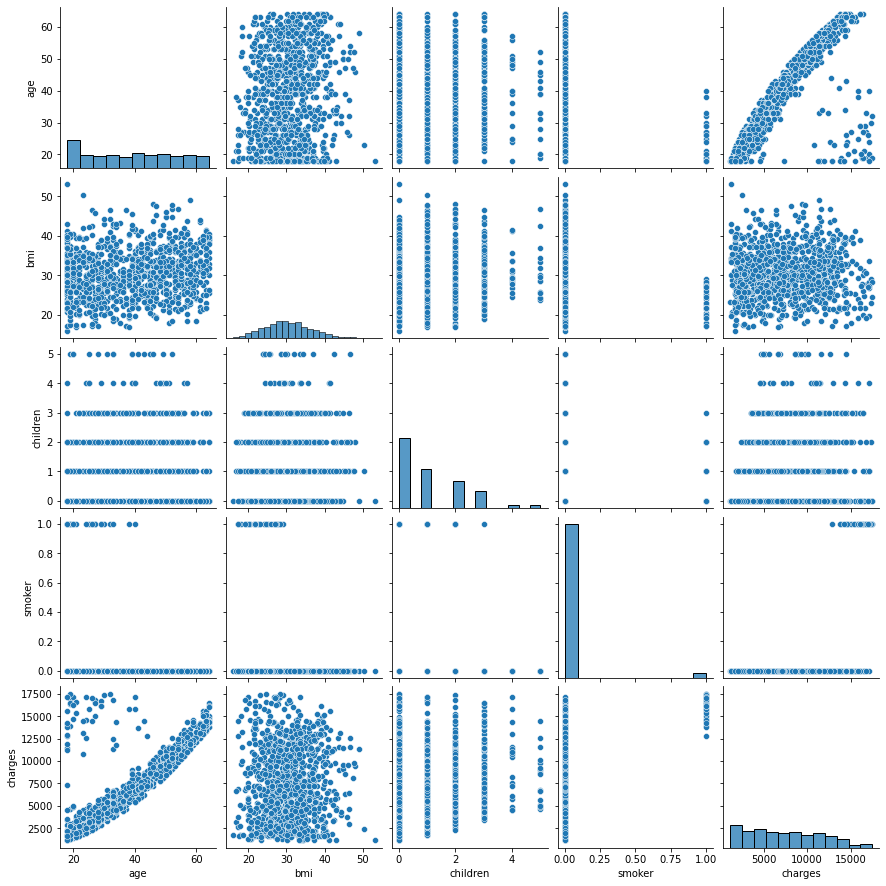

In [163]:
sns.pairplot(df_insurance_cleaned)

### Uncovering Relationships
- It is a known fact that our susceptibility to diseases increases as we put on age, hence higher charges tend to be claimed in people of older ages. This is an evident relation that is being seen in the pairplot above. We can see that the age is almost quadratically related to the charges that are claimed, except for a few outliers.

In [164]:
df_insurance_cleaned["age^2"] = df_insurance_cleaned["age"].apply(lambda item: item**2)
df_insurance_cleaned

,age,sex,bmi,children,smoker,region,charges,age^2
0,19,female,27.90,0,1,southwest,16884.9240,361
1,18,male,33.77,1,0,southeast,1725.5523,324
2,28,male,33.00,3,0,southeast,4449.4620,784
4,32,male,28.88,0,0,northwest,3866.8552,1024
5,31,female,25.74,0,0,southeast,3756.6216,961
...,...,...,...,...,...,...,...,...
1332,52,female,44.70,3,0,southwest,11411.6850,2704
1333,50,male,30.97,3,0,northwest,10600.5483,2500
1334,18,female,31.92,0,0,northeast,2205.9808,324
1335,18,female,36.85,0,0,southeast,1629.8335,324


### Feature and Target Selection
- With all the observations made and inferences made, we have our features as ["age^2", "bmi", "children", "smoker"] and the target as ["charges"].
- Let us initialise the process with all the starter code needed for doing the Multiple Linear Regression.

In [165]:
df_insurance_feature, df_insurance_target = get_features_targets(df_insurance_cleaned, ["age^2", "bmi", "children", "smoker"], ["charges"])
df_insurance_features = normalize_z(df_insurance_feature)
df_insurance_feature_train, df_insurance_feature_test, df_insurance_target_train, df_insurance_target_test = split_data(df_insurance_features, df_insurance_target, random_state=1000, test_size=0.6)

X = prepare_feature(df_insurance_feature_train)
target = prepare_target(df_insurance_target_train)
beta_new = np.zeros((5,1))

[[7535.01746048]
 [3502.6651852 ]
 [  66.85287637]
 [ 630.00397567]
 [2173.88566312]]


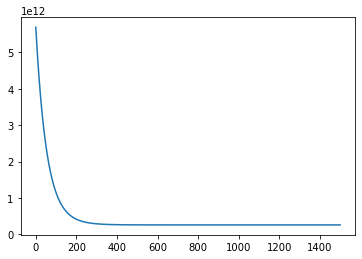

In [166]:
beta, J_storage = gradient_descent(X, target, beta_new, 0.01, 1500)
print(beta)
plt.plot(J_storage)

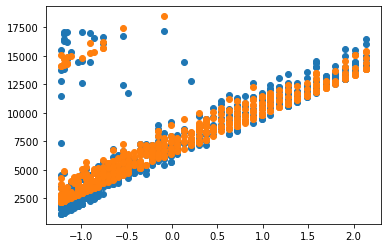

In [167]:
pred = predict(df_insurance_feature_test, beta)
target = prepare_target(df_insurance_target_test)
plt.scatter(df_insurance_feature_test["age^2"], target)
plt.scatter(df_insurance_feature_test["age^2"], pred)

put in perspective all the predicted vs target graphs and lay the legend for orange being what and blue being what, put labels as well

In [168]:
r2score = r2_score(target, pred)
rmse = (mean_squared_error(target, pred))**0.5
print(r2score, rmse)

0.9250249478308998 1151.399200474502


the 17.5k and above dont have any particular observable relation hence we have cleaned the data to only include less than 17.5k

      age     sex     bmi  children  smoker     region      charges   bmi^0.5
3      33    male  22.705         0       0  northwest  21984.47061  4.764976
9      60  female  25.840         0       0  northwest  28923.13692  5.083306
11     62  female  26.290         0       1  southeast  27808.72510  5.127377
14     27    male  42.130         0       1  southeast  39611.75770  6.490763
19     30    male  35.300         0       1  southwest  36837.46700  5.941380
...   ...     ...     ...       ...     ...        ...          ...       ...
1314   30  female  23.655         3       1  northwest  18765.87545  4.863641
1318   35    male  39.710         4       0  northeast  19496.71917  6.301587
1321   62    male  26.695         0       1  northeast  28101.33305  5.166720
1328   23  female  24.225         2       0  northeast  22395.74424  4.921890
1337   61  female  29.070         0       1  northwest  29141.36030  5.391660

[242 rows x 8 columns]


/var/folders/yy/rcnbsh9d65s6m7lnl3jl85lw0000gn/T/ipykernel_6472/672792683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_copy2["smoker"] = df_insurance_copy2["smoker"].apply(smokermapping)
/var/folders/yy/rcnbsh9d65s6m7lnl3jl85lw0000gn/T/ipykernel_6472/672792683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_insurance_copy2["bmi^0.5"] = df_insurance_copy2["bmi"].apply(lambda item: item**0.5)


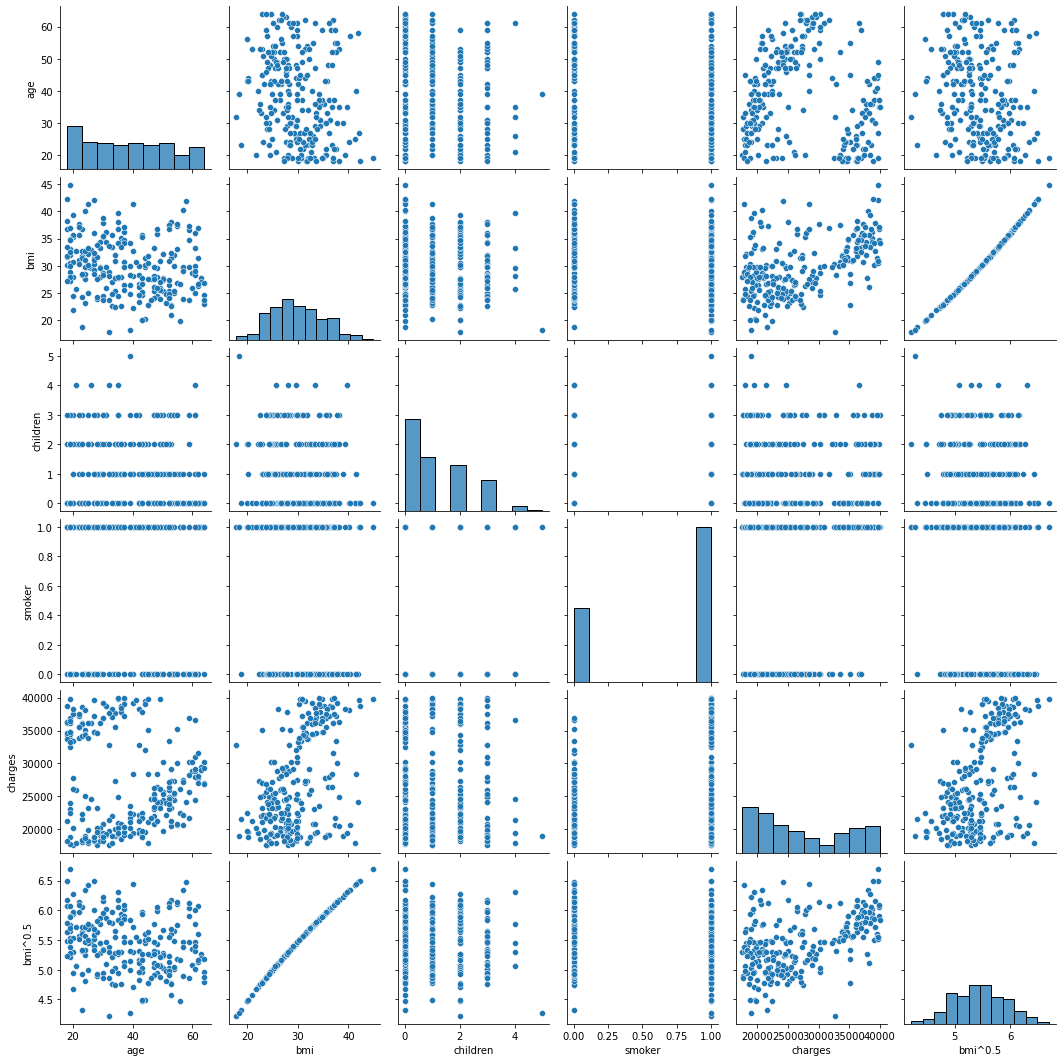

In [169]:
df_insurance_copy2 = df_insurance.copy()
rowselector = (df_insurance["charges"]>=17500)&(df_insurance["charges"]<=40000)
df_insurance_copy2 = df_insurance.loc[rowselector, :]
df_insurance_copy2["smoker"] = df_insurance_copy2["smoker"].apply(smokermapping)
df_insurance_copy2["bmi^0.5"] = df_insurance_copy2["bmi"].apply(lambda item: item**0.5)
print(df_insurance_copy2)
sns.pairplot(df_insurance_copy2)

In [170]:
df_rest_feature, df_rest_target = get_features_targets(df_insurance_copy2, ["age", "bmi^0.5", "smoker", "children"], ["charges"])
df_rest_features = normalize_z(df_rest_feature)
df_rest_features_train, df_rest_features_test, df_rest_target_train, df_rest_target_test = split_data(df_rest_features, df_rest_target, random_state=1000, test_size=0.6)

X = prepare_feature(df_rest_features_train)
target = prepare_target(df_rest_target_train)
beta_2 = np.zeros((5,1))

[[ 2.71175279e+04]
 [-4.91665191e+00]
 [ 3.80597621e+03]
 [ 1.41080011e+03]
 [-2.86983508e+02]]


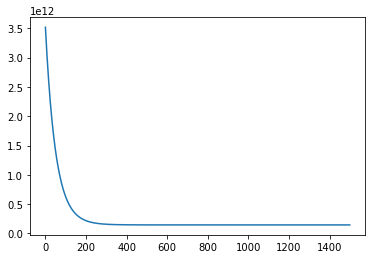

In [171]:
beta, J_storage = gradient_descent(X, target, beta_2, 0.01, 1500)
print(beta)
plt.plot(J_storage)

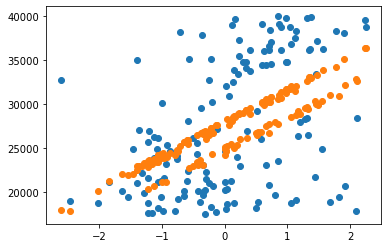

In [172]:
pred = predict(df_rest_features_test, beta)
target = prepare_target(df_rest_target_test)
plt.scatter(df_rest_features_test["bmi^0.5"], target)
plt.scatter(df_rest_features_test["bmi^0.5"], pred)

In [173]:
rscore = r2_score(target, pred)
rmse = (mean_squared_error(target, pred))**0.5
print(rscore, rmse)

0.33479571724079304 6024.121336783232
